In [1]:
import reciprocalspaceship as rs
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import gemmi as gm
import seaborn as sns
import matplotlib.gridspec as gridspec

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 18,
    #"font.family" : "sans-serif",
    #"font.sans-serif" : ["Nimbus Sans"],
}
plt.rcParams.update(new_rc_params)
directory_search_pattern = "careless_runs/" #directory in which to search for tabular outputs. 

This notebook is for calculating, compiling, and visualizing merging statistics. 

In [2]:
def get_careless_params(dirpath):
#     print(os.path.join(dirpath, 'inputs_params.log'))
    with open(os.path.join(dirpath, 'inputs_params.log')) as params:
        line = params.readline()
        line = params.readline()
        args_list=line.split('--')
#             print(args_list)
        p_={}
        bDisableImageScale=False
        for tag in args_list:
            if 'dmin' in tag:
                p_['DMIN']=tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-frequencies' in tag:
                p_['PEF'] =tag.split('=')[1].split(' ')[0]
            if 'iterations' in tag:
                p_['ITER']=tag.split('=')[1].split(' ')[0]
            if 'mlp-layers' in tag:
                p_['MLPL']=tag.split('=')[1].split(' ')[0]
            if 'studentt-likelihood-dof' in tag:
                p_['STDOF'] =tag.split('=')[1].split(' ')[0]
            if 'image-layers' in tag:
                p_['IL']  =tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-keys' in tag:
                p_['PE-keys']=tag.split('=')[1].split(' ')[0]
            if 'seed' in tag:
                p_['SEED']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-parents' in tag:
                p_['DW_list']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-r' in tag:
                DWr_list = tag.split('=')[1]
                p_['rDW']  = DWr_list.split(',')[-1]
            if 'disable-image-scales' in tag:
                bDisableImageScale=True
            if 'refine-uncertainties' in tag:
                p_['RU']=1
        if bDisableImageScale:
            p_['IL']=-1
        if 'STDOF' not in p_:
            p_['STDOF']=-1
        if 'RU' not in p_:
            p_['RU']=0
        if 'PEF' not in p_:
            p_['PEF']=0
        if 'rDW' not in p_:
            p_['rDW']=-1
        run_param=pd.DataFrame(data=p_,index=[0])
        run_param.DMIN  = run_param.DMIN.astype( 'float')
        run_param.SEED  = run_param.SEED.astype( 'int64')
        run_param.ITER  = run_param.ITER.astype( 'int64')
        run_param.STDOF = run_param.STDOF.astype('float')
        run_param.RU    = run_param.RU.astype(   'int64')
        run_param.MLPL  = run_param.MLPL.astype( 'int64')
        run_param.IL    = run_param.IL.astype(   'int64')
        run_param.rDW   = run_param.rDW.astype(  'float')
        run_param.PEF   = run_param.PEF.astype(  'int64')
        return run_param

### Run scripts to calculate merging statistics

We calculate merging statistics with a set of scripts in `./scripts`. repeats for the CCpred calculation are found in `careless_runs_pred`. 

In [3]:
!pwd

/n/hekstra_lab/projects/dw-examples/lysozyme


In [4]:
%%bash

sh ./scripts/1_HEWL_anom_unfriedelize.sh

Process is interrupted.


In [22]:
%%bash

sh ./scripts/2_HEWL_anom_refine.sh

Submitted batch job 22877211


In [32]:
%%bash

sh ./scripts/3_HEWL_anom_peak_heights.sh

In [3]:
%%bash

sh ./scripts/run_ccs.sh merge_HEWL_dw_mlp32_PEF_*

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.00000_0999_dmin1.73_12172279_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.00000_0999_dmin1.73_12172279_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.50000_0999_dmin1.73_12172373_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.50000_0999_dmin1.73_12172373_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.87500_0999_dmin1.73_12172593_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.87500_0999_dmin1.73_12172593_poly


/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/software/careless/careless/stats/ccpred.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_12172665_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_12172665_poly


/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/software/careless/careless/stats/ccpred.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.96875_0999_dmin1.73_12172775_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.96875_0999_dmin1.73_12172775_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0999_dmin1.73_12172866_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0999_dmin1.73_12172866_poly


/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/software/careless/careless/stats/ccpred.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99219_0999_dmin1.73_12172949_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99219_0999_dmin1.73_12172949_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99609_0999_dmin1.73_12173005_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99609_0999_dmin1.73_12173005_poly


/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/software/careless/careless/stats/ccpred.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0999_dmin1.73_12173055_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0999_dmin1.73_12173055_poly


/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/software/careless/careless/stats/ccpred.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99902_0999_dmin1.73_12173102_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99902_0999_dmin1.73_12173102_poly


/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/software/careless/careless/stats/ccpred.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0999_dmin1.73_12173182_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0999_dmin1.73_12173182_poly


/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/software/careless/careless/stats/ccpred.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0999_dmin1.73_12173255_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0999_dmin1.73_12173255_poly


/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/software/careless/careless/stats/ccpred.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_12173327_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_12173327_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_Rneg1_0999_dmin1.73_12173405_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_Rneg1_0999_dmin1.73_12173405_poly


# Importing $CC_\text{pred}$

We now import overall CCpred values from each of the repeats. 

In [3]:
count=0
results_list=[]
params_list=[]
id_list=[]

directory_search_pattern_pred= "careless_runs_pred/" 
for dirpath, dirnames, filenames in os.walk("."):
    if ('ccpred_overall_careless.csv' in filenames) and (directory_search_pattern_pred in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccpred_overall_careless.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        results_list.append(tmp)
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        params_list.append(careless_params)

all_params =pd.concat(params_list)
all_results_ccpred=pd.concat(results_list)

./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_22880695_poly
Read-in values of grid_id: 0.93750,  job_id: 22880695
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.50000_0999_dmin1.73_22881098_poly
Read-in values of grid_id: 0.50000,  job_id: 22881098
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.99951_0999_dmin1.73_22880949_poly
Read-in values of grid_id: 0.99951,  job_id: 22880949
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.00000_0999_dmin1.73_22880953_poly
Read-in values of grid_id: 0.00000,  job_id: 22880953
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.87500_0999_dmin1.73_22881145_poly
Read-in values of grid_id: 0.87500,  job_id: 22881145
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.99609_0999_dmin1.73_22881150_poly
Read-in values of grid_id: 0.99609,  job_id: 22881150
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.96875_0999_dmin1.73_22880992_poly
Read-in values of grid_id: 0.96875,  job_id: 22880992
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.

### Importing $CC_\text{1/2}$

We import $CC_\text{1/2}$ values from each of the *half-dataset* repeats in `./careless_runs`. 

In [4]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('cchalf_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'cchalf_overall.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        
        results_list.append(tmp)
all_results_cchalf=pd.concat(results_list)

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
Read-in values of grid_id: 0.75000,  job_id: 12172443
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0999_dmin1.73_12173055_poly
Read-in values of grid_id: 0.99805,  job_id: 12173055
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.96875_0999_dmin1.73_12172775_poly
Read-in values of grid_id: 0.96875,  job_id: 12172775
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_12172665_poly
Read-in values of grid_id: 0.93750,  job_id: 12172665
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0999_dmin1.73_12172866_poly
Read-in values of grid_id: 0.98438,  job_id: 12172866
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_12173327_poly
Read-in values of grid_id: 0.99990,  job_id: 12173327
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0999_dmin1.73_12173182_poly
Read-in values of grid_id: 0.99951,  job_id: 12173182
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0999_dmin1.73_12173255_poly
Read-i

### Importing $CC_\text{anom}$

We import $CC_\text{anom}$ values from each of the *half-dataset* repeats in `./careless_runs`. 

In [5]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('ccanom_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccanom_overall.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        
        results_list.append(tmp)
all_results_ccanom=pd.concat(results_list)

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
Read-in values of grid_id: 0.75000,  job_id: 12172443
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0999_dmin1.73_12173055_poly
Read-in values of grid_id: 0.99805,  job_id: 12173055
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.96875_0999_dmin1.73_12172775_poly
Read-in values of grid_id: 0.96875,  job_id: 12172775
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_12172665_poly
Read-in values of grid_id: 0.93750,  job_id: 12172665
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0999_dmin1.73_12172866_poly
Read-in values of grid_id: 0.98438,  job_id: 12172866
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_12173327_poly
Read-in values of grid_id: 0.99990,  job_id: 12173327
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0999_dmin1.73_12173182_poly
Read-in values of grid_id: 0.99951,  job_id: 12173182
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0999_dmin1.73_12173255_poly
Read-i

### Importing anomalous peak heights

We now import anomalous peak heights per csv file generated by `3_HEWL_anom_peak_heights.sh`.

In [6]:
all_results_peak_heights=pd.read_csv("HEWL_anom_peak_heights.csv").rename(columns={"frames":"grid_id"})

In [7]:
all_results_peak_heights["grid_id"]=all_results_peak_heights["grid_id"].round(5)

In [8]:
all_params.reset_index(drop=True,inplace=True)
#all_params.info()
all_params.head(10)

,MLPL,IL,PEF,PE-keys,DMIN,ITER,SEED,DW_list,rDW,STDOF,RU,grid_id,job_id
0,10,0,4,"xcal,ycal,BATCH",1.73,30000,26446,"None,0",0.93750,64.0,0,0.93750,22880695
1,10,0,4,"xcal,ycal,BATCH",1.73,30000,3216,"None,0",0.50000,64.0,0,0.50000,22881098
2,10,0,4,"xcal,ycal,BATCH",1.73,30000,28528,"None,0",0.99951,64.0,0,0.99951,22880949
3,10,0,4,"xcal,ycal,BATCH",1.73,30000,379,"None,0",0.00000,64.0,0,0.00000,22880953
4,10,0,4,"xcal,ycal,BATCH",1.73,30000,21753,"None,0",0.87500,64.0,0,0.87500,22881145
5,10,0,4,"xcal,ycal,BATCH",1.73,30000,30178,"None,0",0.99609,64.0,0,0.99609,22881150
6,10,0,4,"xcal,ycal,BATCH",1.73,30000,17446,"None,0",0.96875,64.0,0,0.96875,22880992
7,10,0,4,"xcal,ycal,BATCH",1.73,30000,13476,"None,0",0.98438,64.0,0,0.98438,22881148
8,10,0,4,"xcal,ycal,BATCH",1.73,30000,28228,"None,0",0.75000,64.0,0,0.75000,22880955
9,10,0,4,"xcal,ycal,BATCH",1.73,30000,3875,"None,0",0.99976,64.0,0,0.99976,22880999


In [9]:
all_results_peak_heights = all_results_peak_heights.sort_values(by="grid_id")
all_results_peak_heights.rename(columns={"grid_id":"rDW"}, inplace=True)
#all_results_peak_heights.set_index("rDW", inplace=True)

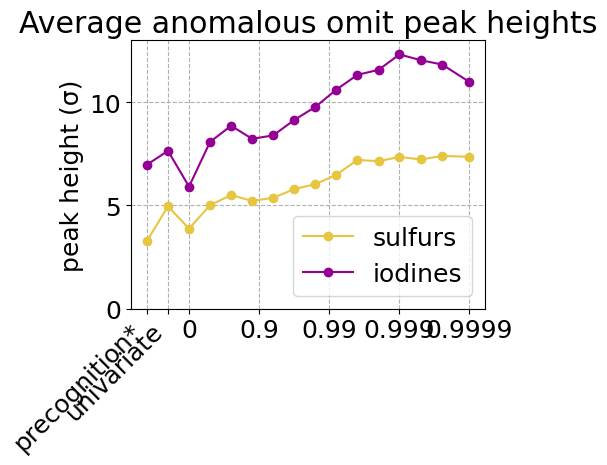

In [10]:
sulfur_atoms = []
iodine_atoms = []
for name in all_results_peak_heights.columns:
    if name[:3] == "IOD":
        iodine_atoms.append(name)
    else:
        sulfur_atoms.append(name)

iodines = all_results_peak_heights[iodine_atoms].mean(axis=1).to_numpy()
sulfurs = all_results_peak_heights[sulfur_atoms].mean(axis=1).to_numpy()

fig,ax = plt.subplots(figsize=[5.5,5])
plt.plot(np.log10(1-all_results_peak_heights["rDW"]),sulfurs,'o-',c=(0.9,0.775,0.25),label="sulfurs")
plt.plot(np.log10(1-all_results_peak_heights["rDW"]),iodines,'o-',c=(0.580392157,0.0,0.580392157),label="iodines")
plt.grid(linestyle="--")

plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303, 0.606],labels=["0.9999","0.999","0.99","0.9","0","univariate","precognition*"])
ax.set_ylim([0,13])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ticks[-2].set_rotation(45)
ticks[-2].set_ha("right")
ax.legend(loc='lower right')
plt.title("Average anomalous omit peak heights")
plt.ylabel("peak height (σ)")
plt.tight_layout()
plt.savefig("average_peak_heights.svg",bbox_inches="tight")
plt.show()

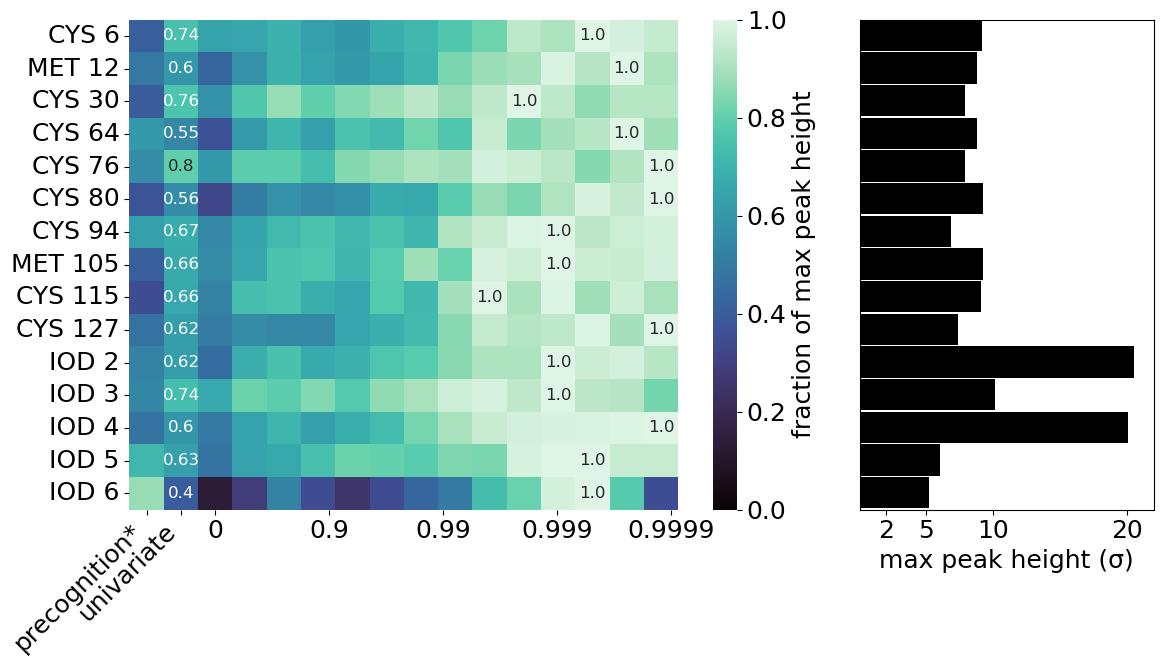

In [136]:
table = all_results_peak_heights.transpose()

table.drop(["rDW"],inplace=True)

max_table = table.max(axis="columns").to_numpy()
table = table.div(max_table, axis='rows')

def threshold(x):
    return '' if x<1 else np.round(x,1)
table_labels = table.applymap(threshold)
table_labels.iloc[:,1] = np.round(table.iloc[:,1],2)

fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 0.3])

ax1 = plt.subplot(gs[0])
sns.heatmap(table, ax=ax1, 
            cmap="mako",
            cbar_kws={'label': 'fraction of max peak height'},
            annot=table_labels,
            annot_kws={"fontsize":12},
            fmt = '')


xticks = (2.5-np.log2(1-np.array([-3,-1,0,0.9,0.99,0.999,0.9999])))
ax1.set_xticks(xticks)
ax1.set_xticklabels(["precognition*","univariate","0","0.9","0.99","0.999","0.9999"])

ticks = ax1.get_xticklabels()
for ind,tick in enumerate(ticks):
    if ind == 0 or ind == 1:
        tick.set_rotation(45)
        tick.set_ha("right")
    else:
        tick.set_rotation(0)

ax1.collections[0].set_clim(0,1) 

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.barh(table.index, max_table, color='k', height=0.96, align='edge')
ax2.tick_params(left=False, labelleft=False)
#ax2.set_xscale("log")
ax2.set_xlim([0,22])
ax2.set_xticks([2,5,10,20])
ax2.set_xticklabels([2,5,10,20])
ax2.set_xlabel('max peak height (σ)')
plt.tight_layout()
plt.savefig("peak_heights.svg",bbox_inches="tight")

In [11]:
all_results_ccpred = pd.melt(all_results_ccpred, id_vars=['file', 'grid_id','job_id','Resolution Range (Å)','test'], value_vars=['CCpred'])
all_results_ccpred.rename(columns={'value': 'CCpred'}, inplace=True)
pivoted_df = all_results_ccpred.pivot(index=['file', 'grid_id','job_id','Resolution Range (Å)'], columns='test', values='CCpred')
pivoted_df.rename(columns={'Test': 'CCpred_test','Train': 'CCpred_train'}, inplace=True)
all_results_ccpred = pivoted_df.reset_index()

In [12]:
all_results_ccpred

test,file,grid_id,job_id,Resolution Range (Å),CCpred_test,CCpred_train
0,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0000,22880688,55.38 - 1.73,0.868159,0.869629
1,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0000,22880952,55.38 - 1.73,0.868537,0.869675
2,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0000,22881001,55.38 - 1.73,0.867187,0.869354
3,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0000,22880688,55.38 - 1.73,0.865058,0.866225
4,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0000,22880952,55.38 - 1.73,0.865718,0.866172
...,...,...,...,...,...,...
85,HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_predi...,0.9999,22881000,55.38 - 1.73,0.869044,0.869347
86,HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_predi...,0.9999,22881278,55.38 - 1.73,0.868294,0.868940
87,HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_predi...,0.9999,22880951,55.38 - 1.73,0.865126,0.865877
88,HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_predi...,0.9999,22881000,55.38 - 1.73,0.865891,0.866120


In [13]:
all_params.reset_index(drop=True,inplace=True)
all_results_ccpred.dropna(inplace=True)
all_results_ccpred["delay"] = [name[-5] for name in all_results_ccpred.file]
all_results_ccpred["delay"]=all_results_ccpred["delay"].astype('int32')
all_results_ccpred.sort_values(by=["grid_id","job_id"],inplace=True)
all_results_ccpred.reset_index(inplace=True)
print(all_results_ccpred.count())
all_results_ccpred.head()

test
index                   90
file                    90
grid_id                 90
job_id                  90
Resolution Range (Å)    90
CCpred_test             90
CCpred_train            90
delay                   90
dtype: int64


test,index,file,grid_id,job_id,Resolution Range (Å),CCpred_test,CCpred_train,delay
0,0,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0,22880688,55.38 - 1.73,0.868159,0.869629,0
1,3,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0,22880688,55.38 - 1.73,0.865058,0.866225,1
2,1,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0,22880952,55.38 - 1.73,0.868537,0.869675,0
3,4,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0,22880952,55.38 - 1.73,0.865718,0.866172,1
4,2,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.73_prediction...,-1.0,22881001,55.38 - 1.73,0.867187,0.869354,0


We clean each of the dataframes generated and then combine them together. First, we compute a mean and standard deviation for the CCpreds.

In [14]:
all_results_ccpred = all_results_ccpred[["grid_id","delay","CCpred_test","CCpred_train"]].groupby(by=["grid_id","delay"])
all_results_ccpred = all_results_ccpred.agg(CCpred_test=("CCpred_test","mean"),
                                            CCpred_test_std=("CCpred_test","std"),
                                            CCpred_train=("CCpred_train","mean"),
                                            CCpred_train_std=("CCpred_train","std"),
                                            grid_id=("grid_id","first"),
                                            delay=("delay","first")).reset_index(drop=True)
all_results_ccpred["grid_id"]=all_results_ccpred["grid_id"].round(5)

In [15]:
def rms(row):
    return np.sqrt(np.sum(row**2))

In [16]:
all_results_ccpred = all_results_ccpred.groupby(by=["grid_id"])
all_results_ccpred = all_results_ccpred.agg(CCpred_test=("CCpred_test","mean"),
                                            CCpred_test_std=("CCpred_test_std",rms),
                                            CCpred_train=("CCpred_train","mean"),
                                            CCpred_train_std=("CCpred_train_std",rms),
                                            grid_id=("grid_id","first")).reset_index(drop=True)

we clean `cchalf`,`ccanom`, and `peak heights` tables and then merge on the grid id by `pandas`.

In [17]:
all_results = all_results_ccpred.merge(all_results_peak_heights,on="grid_id")

In [18]:
all_results_ccanom1 = all_results_ccanom[["CCanom","grid_id","job_id","bin"]]
all_results_ccanom1 = all_results_ccanom1.groupby(by=["job_id"]).agg(CCanom=("CCanom","mean"),CCanom_std=("CCanom","std"),grid_id=("grid_id","first")).reset_index(drop=True)
all_results_ccanom1["grid_id"]=all_results_ccanom1["grid_id"].round(5)

In [19]:
all_results_cchalf1 = all_results_cchalf[["CChalf","grid_id","job_id","bin"]]
all_results_cchalf1 = all_results_cchalf1.groupby(by=["job_id"]).agg(CChalf=("CChalf","mean"),CChalf_std=("CChalf","std"),grid_id=("grid_id","first")).reset_index(drop=True)
all_results_cchalf1["grid_id"]=all_results_cchalf1["grid_id"].round(5)


In [20]:
all_results = all_results.merge(all_results_ccanom1,on="grid_id")
all_results = all_results.merge(all_results_cchalf1,on="grid_id")
all_results = all_results.rename(columns={"grid_id":"rDW"})

In [21]:
all_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CCpred_test       15 non-null     float64
 1   CCpred_test_std   15 non-null     float64
 2   CCpred_train      15 non-null     float64
 3   CCpred_train_std  15 non-null     float64
 4   rDW               15 non-null     float64
 5   CYS 6             15 non-null     float64
 6   MET 12            15 non-null     float64
 7   CYS 30            15 non-null     float64
 8   CYS 64            15 non-null     float64
 9   CYS 76            15 non-null     float64
 10  CYS 80            15 non-null     float64
 11  CYS 94            15 non-null     float64
 12  MET 105           15 non-null     float64
 13  CYS 115           15 non-null     float64
 14  CYS 127           15 non-null     float64
 15  IOD 2             15 non-null     float64
 16  IOD 3             15 non-null     float64
 17 

finally, we plot statistics. 

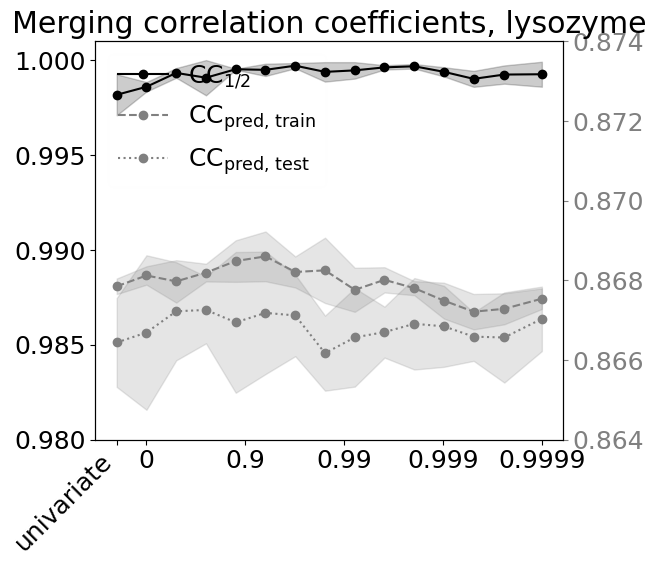

In [24]:
tmp=all_results.copy()
tmp=tmp.sort_values(by=["rDW"])

fig,ax = plt.subplots(figsize=(7,6))

lns1 = ax.plot(np.log10(1-tmp["rDW"]),tmp["CChalf"],'ko-',label=r"CC$_\text{1/2}$")
plt.fill_between(np.log10(1-tmp["rDW"]), 
                 tmp["CChalf"] - tmp["CChalf_std"], 
                 tmp["CChalf"] + tmp["CChalf_std"], 
                 color='k', alpha=0.2)

ax2 = ax.twinx()
lns2 = ax2.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_train"],'o--',color="gray",label=r"CC$_\text{pred, train}$")
ax2.fill_between(np.log10(1-tmp["rDW"]), 
                 tmp["CCpred_train"] - tmp["CCpred_train_std"], 
                 tmp["CCpred_train"] + tmp["CCpred_train_std"], 
                 color='gray', alpha=0.2)

lns3 = ax2.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_test"],'o:',color="gray",label=r"CC$_\text{pred, test}$")
ax2.fill_between(np.log10(1-tmp["rDW"]), 
                 tmp["CCpred_test"] - tmp["CCpred_test_std"], 
                 tmp["CCpred_test"] + tmp["CCpred_test_std"], 
                 color='gray', alpha=0.2)

plt.title("Merging correlation coefficients, lysozyme")
plt.xlabel("double-Wilson $r$")

#plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
ax.set_ylim([0.98,1.001])
ax2.set_ylim([0.864,0.874])

ax2.tick_params(axis='y', colors='gray')
ax2.yaxis.label.set_color('gray')

ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left',framealpha=0.01)

plt.tight_layout()
plt.savefig("CCs.svg",bbox_inches="tight")
plt.show()

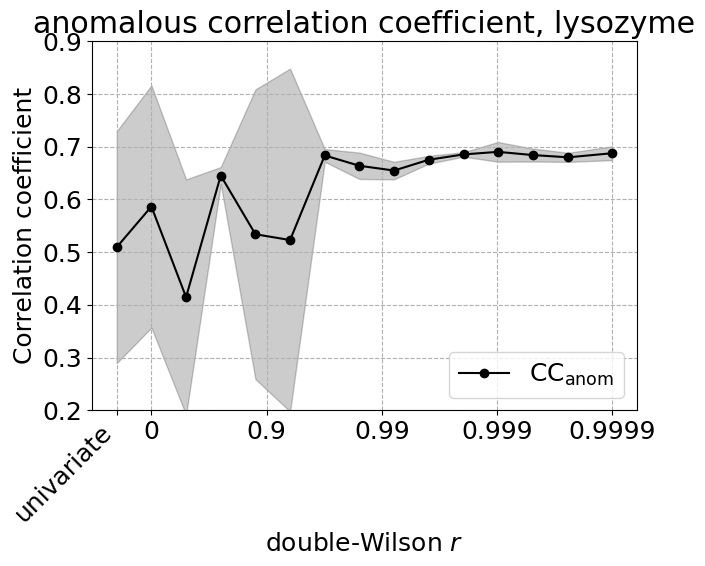

In [25]:
fig,ax = plt.subplots(figsize=(7,6))

plt.plot(np.log10(1-tmp["rDW"]),tmp["CCanom"],'ko-',label=r"CC$_\text{anom}$")
plt.fill_between(np.log10(1-tmp["rDW"]), tmp["CCanom"] - tmp["CCanom_std"], tmp["CCanom"] + tmp["CCanom_std"], color='k', alpha=0.2)

plt.grid(linestyle="--")
plt.title("anomalous correlation coefficient, lysozyme")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
plt.ylim([0.2,0.9])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("CCanom.svg",bbox_inches="tight")
plt.show()

In [26]:
all_results_peak_heights = all_results_peak_heights.sort_values(by="grid_id")
all_results_peak_heights.rename(columns={"grid_id":"rDW"}, inplace=True)
all_results_peak_heights.set_index("rDW", inplace=True)


ValueError: x and y must have same first dimension, but have shapes (15,) and (16,)

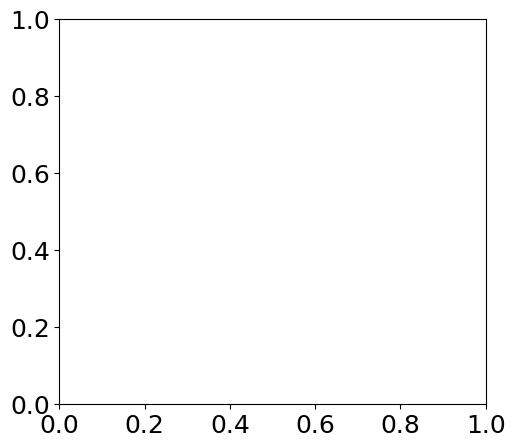

In [27]:
sulfur_atoms = []
iodine_atoms = []
for name in all_results_peak_heights.columns:
    if name[:3] == "IOD":
        iodine_atoms.append(name)
    else:
        sulfur_atoms.append(name)

iodines = all_results_peak_heights[iodine_atoms].mean(axis=1).to_numpy()
sulfurs = all_results_peak_heights[sulfur_atoms].mean(axis=1).to_numpy()

fig,ax = plt.subplots(figsize=[5.5,5])
plt.plot(np.log10(1-tmp["rDW"]),sulfurs,'o-',c=(0.9,0.775,0.25),label="sulfurs")
plt.plot(np.log10(1-tmp["rDW"]),iodines,'o-',c=(0.580392157,0.0,0.580392157),label="iodines")
plt.grid(linestyle="--")

plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303, 0.606],labels=["0.9999","0.999","0.99","0.9","0","univariate","precognition*"])
#ax.set_yscale("log")
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='lower right')
plt.title("Average anomalous omit peak heights")
plt.ylabel("peak height (σ)")
plt.tight_layout()
plt.savefig("average_peak_heights.svg",bbox_inches="tight")
plt.show()

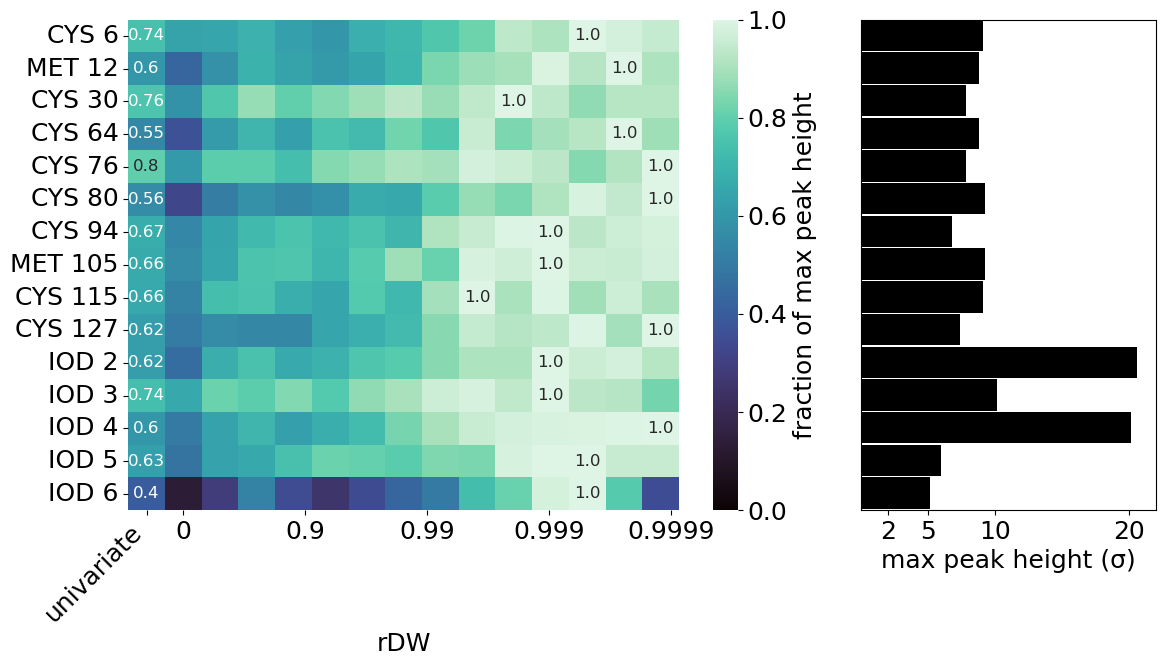

In [24]:
table = all_results_peak_heights.transpose()

max_table = table.max(axis="columns").to_numpy()
table = table.div(max_table, axis='rows')


def threshold(x):
    return '' if x<1 else np.round(x,1)
table_labels = table.applymap(threshold)
table_labels[-1] = np.round(table.iloc[:,0],2)

fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 0.3])

ax1 = plt.subplot(gs[0])
sns.heatmap(table, ax=ax1, 
            cmap="mako",
            cbar_kws={'label': 'fraction of max peak height'},
            annot=table_labels,
            annot_kws={"fontsize":12},
            fmt = '')


xticks = (1.5-np.log2(1-np.array([-2,-1,0,0.9,0.99,0.999,0.9999])))
ax1.set_xticks(xticks)
ax1.set_xticklabels(["precognition*","univariate","0","0.9","0.99","0.999","0.9999"])

ticks = ax1.get_xticklabels()
for ind,tick in enumerate(ticks):
    if ind == 0:
        tick.set_rotation(45)
        tick.set_ha("right")
    else:
        tick.set_rotation(0)

ax1.collections[0].set_clim(0,1) 

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.barh(table.index, max_table, color='k', height=0.96, align='edge')
ax2.tick_params(left=False, labelleft=False)
#ax2.set_xscale("log")
ax2.set_xlim([0,22])
ax2.set_xticks([2,5,10,20])
ax2.set_xticklabels([2,5,10,20])
ax2.set_xlabel('max peak height (σ)')
plt.tight_layout()
plt.savefig("peak_heights.svg",bbox_inches="tight")

In [58]:
%%bash 

mkdir ./pymol
cd pymol
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_R0.99902_0999_dmin1pt73/Refine_4/mlp32_PEF_R0.99902_0999_dmin1pt73_new_refine_2.pdb ./lysozyme_refine.pdb
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_Rneg1_0999_dmin1pt73/Refine_2/mlp32_PEF_Rneg1_0999_dmin1pt73_new_refine_2.mtz lysozyme_refine_univariate.mtz
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_R0.99902_0999_dmin1pt73/Refine_2/mlp32_PEF_R0.99902_0999_dmin1pt73_new_refine_2.mtz ./lysozyme_refine_multivariate.mtz

mkdir: cannot create directory ‘./pymol’: File exists
